# [Titanic Top 4% with ensemble modeling][1]

[1]: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

* **1 Introduction**
* **2 Load and check data**
    * 2.1 load data
    * 2.2 Outlier detection
    * 2.3 joining train and test set
    * 2.4 check for null and missing values
* **3 Feature analysis**
    * 3.1 Numerical values
    * 3.2 Categorical values
* **4 Filling missing Values**
    * 4.1 Age
* **5 Feature engineering**
    * 5.1 Name/Title
    * 5.2 Family Size
    * 5.3 Cabin
    * 5.4 Ticket
* **6 Modeling**
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results
    

## 1. Introduction

세 가지 주요 파트로 나뉜다:

1. **Feature analysis**
2. **Feature engineering**
3. **Ensemble Modeling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


## 2. Load and check data
### 2.1 Load data

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv("./data/titanic/train.csv")
test = pd.read_csv("./data/titanic/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

이상치 탐지하는 함수 만들기

1. df : 데이터, n : n개 이상의 피처에서 사분위범위 울타리를 넘어야 이상치로 판단, features : 이상치 탐지를 원하는 피처명 리스트
2. 각 피처별 사분위수를 구하고 울타리 바깥의 값을 갖는 행들을 outlier_indices에 저장한다.
3. collections 모듈의 counter 클래스를 사용하여 outlier_indices 객체 안에서 각 행들의 반복 횟수를 딕셔너리로 저장한다.
4. 만약 반복수가 n보다 크다면 multiple_outliers라는 객체에 저장하여 이 객체의 행들을 이상치라고 판단한다.

In [3]:
# Outlier detection 

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

train에 대해 수치형 변수 4개에서 이상치를 탐지했으며, 이 중 3개 이상에서 울타리를 넘을 경우 이상치로 판단한다. 이 함수에서 반환된 값, 즉 이상치로 탐지된 행들을 Outliers_to_drop에 저장한다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


총 10개의 이상치가 탐지되었다. 이들을 드랍하고 인덱스를 리셋해준다.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

범주형 변수들에 대한 feature engineering을 동일하게 적용하기 위해 train과 test dataset을 'dataset'이라는 객체로 합친다.

### 2.4 check for null and missing values : 결측치 처리


빈 값들과 NaN값들을 NaN으로 채운 후 총 null값을 확인한다.

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin 변수들에서 결측치가 많은 것을 확인할 수 있다.

target인 'Survived'는 test dataset의 크기인 418과 동일하다. 

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

info()와 isnull()을 통해 null값의 수를 확인한다.

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


describe()를 통해 각종 통계량들을 요약해준다.

## 3. Feature analysis
### 3.1 Numerical values : 수치형 변수

수치형 변수인 SibSp, Parch, Age, Fare와 타겟인 Survived에 대하여 seaborn의 heatmap으로 상관관계를 확인한다.

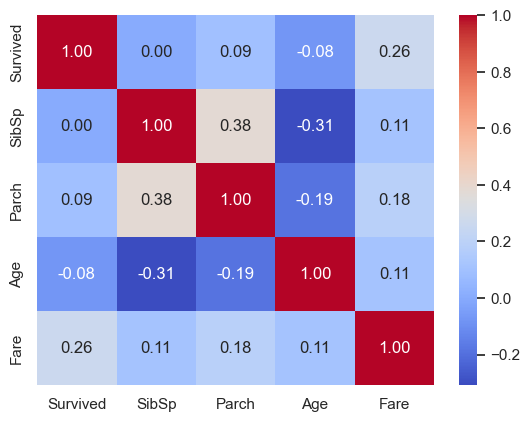

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

Fare변수만 Survival과 유의미한 상관관계를 갖는 것을 확인할 수 있다.

다른 변수들의 유의미하지 않다는 얘기가 아니다. 이 피처들로 이루어진 다른 그룹이 Survival과 상관관계가 있을 수 있다. 따라서 더 탐색해보아야 한다.

#### SibSP : # of siblings / spouses aboard the Titanic	

seaborn의 catplot으로 barplot을 찍어본다. catplot은 범주형변수를 시각화 할 수 있는 함수로, default로 stripplot()을 사용하지만 여기선 barplot으로 시각화한다.

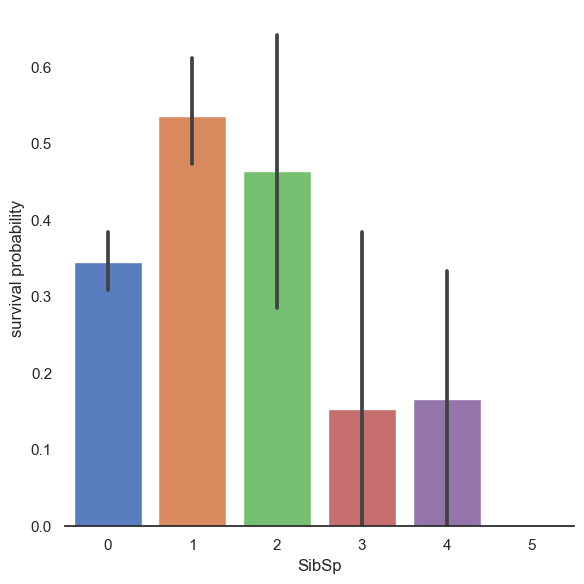

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

3명 이상의 sibling이나 spouse를 갖는 승객의 경우 생존 확률이 더 낮은 것을 확인할 수 있다.

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

#### Parch : # of parents / children aboard the Titanic	

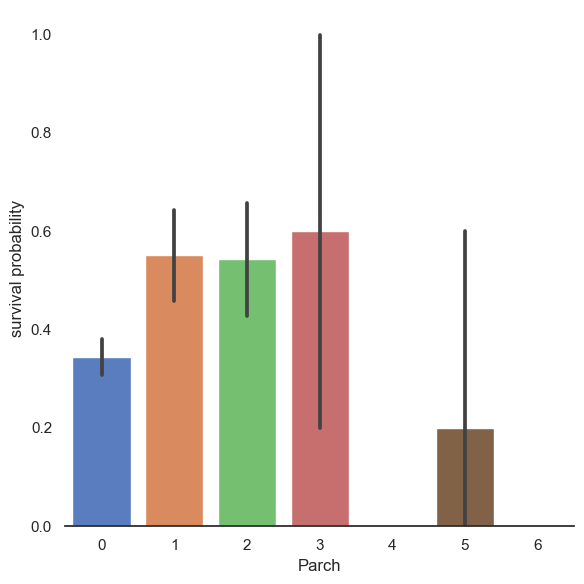

In [14]:
# Explore Parch feature vs Survived
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

부모나 자녀의 수가 1, 2명인 경우가 0, 1, 3, 4, 5, 6인 경우보다 생존률이 높다. 
3인 경우의 생존률 표준편차가 영향 어쩌구

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children 

#### Age

In [15]:
train['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  , 19.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 24.  , 46.  , 59.  , 71.  ,
       23.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

FacetGrid를 통해 Age에 대한 Survived를 시각화. map() 메서드를 이용하여 적용할 변수와 그래프 유형을 그리드 객체에 전달한다.

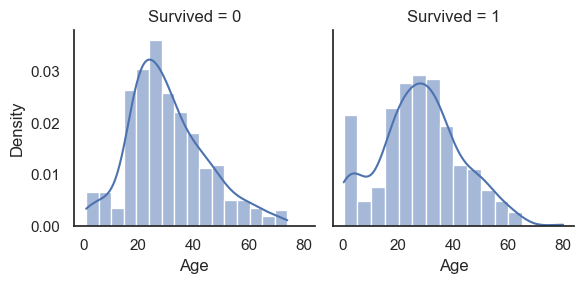

In [16]:
g = sns.FacetGrid(train, col='Survived')
g.map(sns.histplot, "Age", kde=True, stat="density")

Age의 분포는 정규분포 모양을 하고 있다. 

survived와 not survived 분포의 모양이 다른데, 특히 survived 분포의 0-5세에서 피크가 있는 것과 60-80세 사이의 승객이 적은 것을 확인할 수 있다.

즉, Age가 Survived와 상관관계는 없다고 하더라도, 생존 가능성이 더 높거나 낮은 특정 연령층이 존재한다는 것을 알 수 있다. 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\1732533048.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\1732533048.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


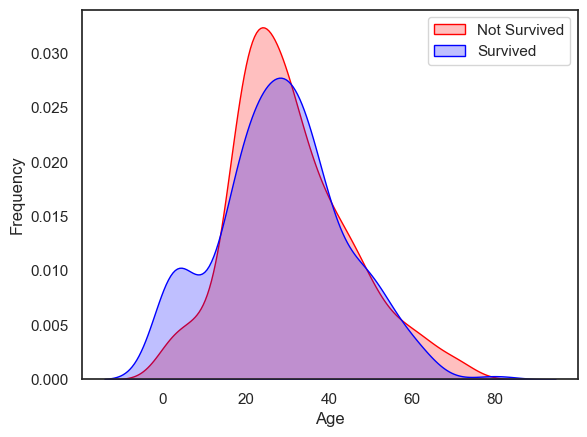

In [17]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

두 kdeplot을 겹쳐보면, 어린아이 연령층에서 피크가 있는 것을 확연하게 볼 수 있다.

#### Fare

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

하나 있는 결측치는 중앙값으로 채워주었다. 이것이 예측에 큰 영향을 주지 않을 것이라고 생각해서.

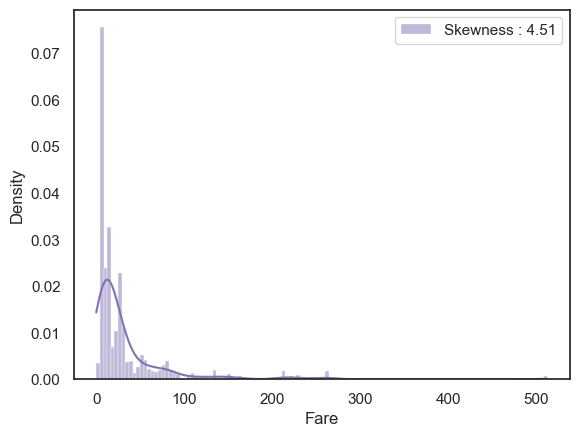

In [20]:
# Explore Fare distribution 
g = sns.histplot(dataset["Fare"], color="m", kde=True, stat="density", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Fare의 histplot을 찍어보았을 때, 매우 skew 된 것을 확인할 수 있다. 이로 인해 모델에서 가중치가 매우 높게 나타날 수 있으니, log transformation을 해주자.

In [21]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

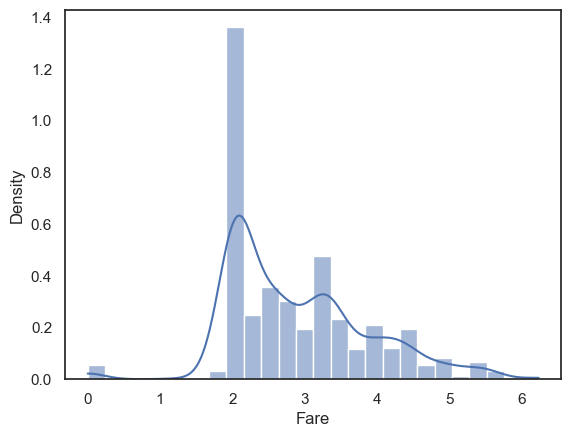

In [22]:
g = sns.histplot(dataset["Fare"], color="b", kde=True, stat="density", label="Skewness : %.2f"%(dataset["Fare"].skew()))

log transformation 후에 왜도가 확실히 줄어든 것을 확인할 수 있다.

### 3.2 Categorical values
#### Sex

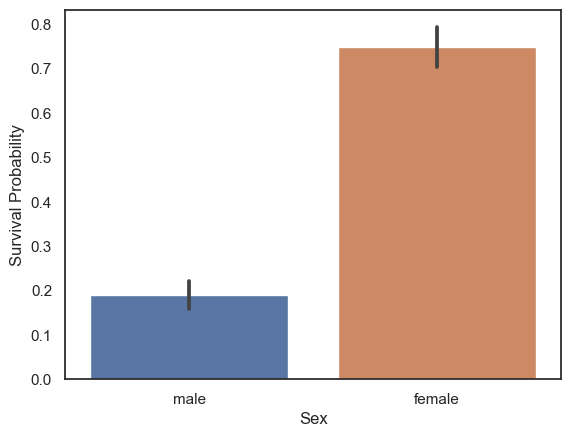

In [23]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


여성의 생존률이 남성의 생존율보다 확연하게 높은 것을 확인할 수 있다. 따라서 성별은 생존율 예측에 중요한 변수라고 할 수 있다.

#### Pclass

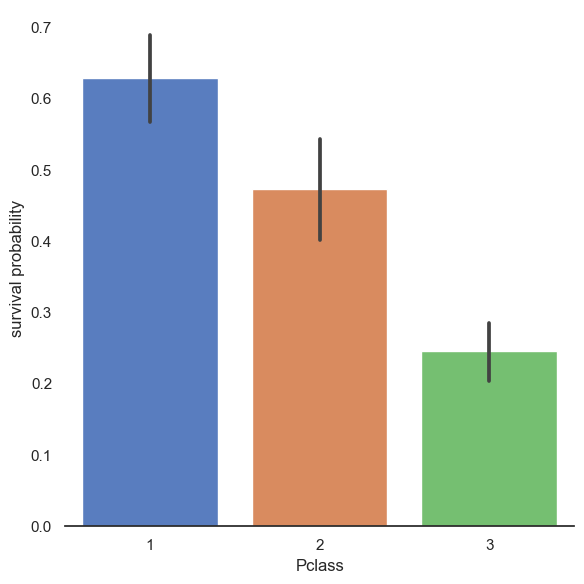

In [25]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height = 6, 
                palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

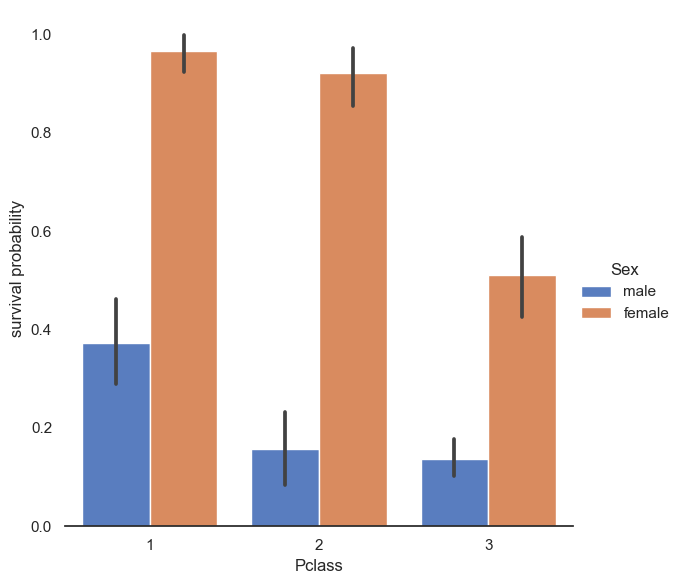

In [26]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", 
                data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

1, 2, 3 등급간의 생존율은 다르다는 것을 확인할 수 있다. 1등급 승객의 생존율이 2, 3등급보다 높으며, 이는 남녀 승객 모두에게서 관측되는 현상이다.

#### Embarked

In [27]:
dataset["Embarked"].isnull().sum()

2

In [28]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

2개의 결측치가 존재하는데, 이는 Embarked 변수에서 가장 많은 관측값인 'S'로 채워준다.

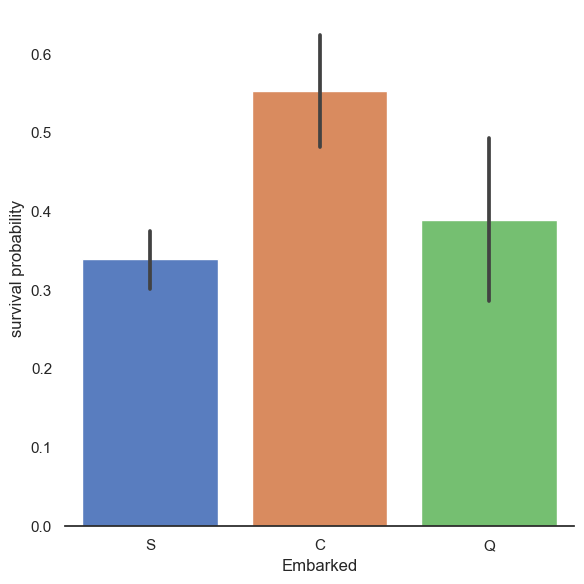

In [29]:
# Explore Embarked vs Survived 
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Cherbourg (C)에서 승선한 승객들의 생존율이 더 높은 것을 확인할 수 있다.

가정 : 1등급 승객의 수가 Queenstown (Q), Southampton (S)에서 보다 Cherbourg (C)에서 더 많은 것으로 생각된다.

가정이 사실일지 Pclass와 Embarked의 분포를 비교해서 확인해보자.

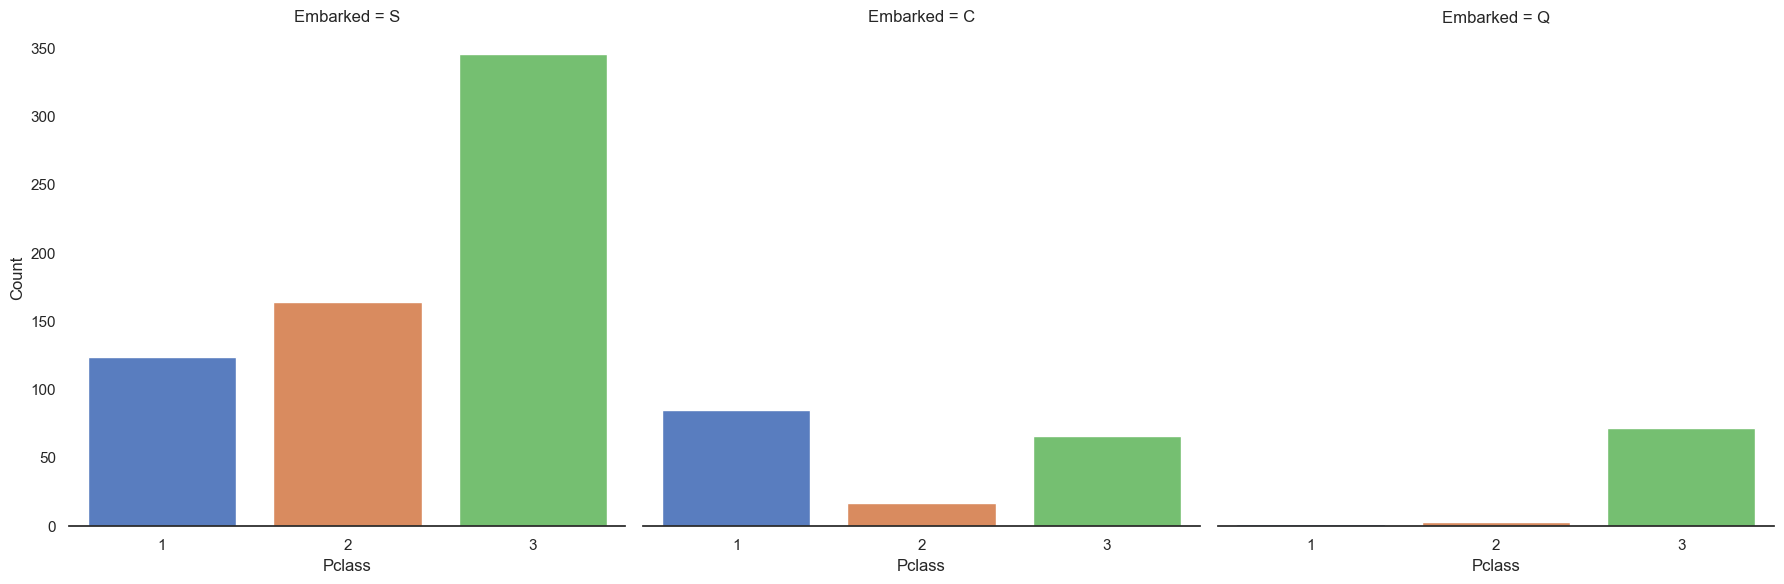

In [30]:
# Explore Pclass vs Embarked 
g = sns.catplot(x="Pclass", col="Embarked",  data=train,
                height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

S와 Q에서 온 승객 중 3등급의 수가 가장 많은 것을 확인할 수 있다. 반면 C에서는 승객 중 1등급의 수가 가장 많은 것을 확인할 수 있다.

그렇지만 아직까지는 1등급의 생존율이 가장 높은 것을 설명할 수 없다. 가정은 1등급 승객들의 영향력 때문에 그들의 구조가 우선시 된 것이라고 생각해볼 수 있다.

## 4. Filling missing Values
### 4.1 Age

Age 변수에는 256개의 결측치가 있다.

현재까지 특정 집단의 생존율이 높은 경우가 있었기 때문에 (아이들의 경우), 이러한 연령 특성을 살려 결측치를 채우고자 한다.
이러한 문제를 해결하기 위해, Age 변수와 상관관계가 높은 변수를 살펴보았다.(Sex, Parch , Pclass and SibSP).

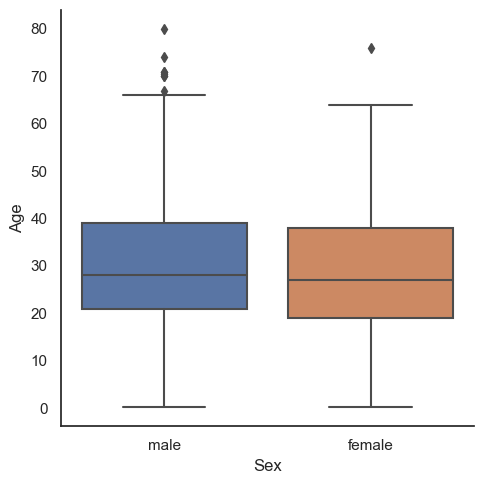

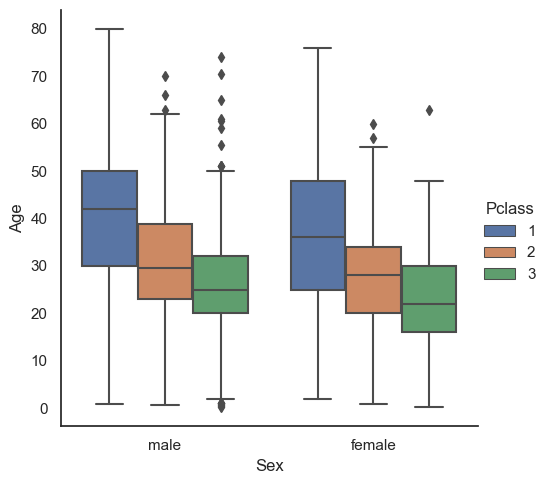

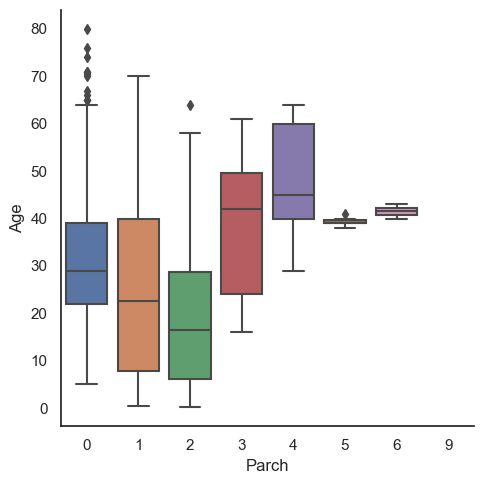

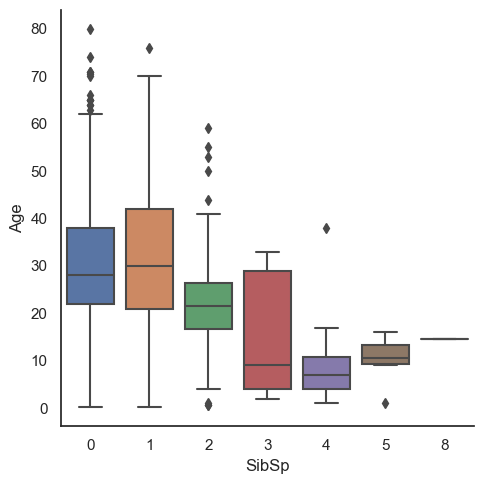

In [31]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

여성과 남성의 연령 분포는 비슷하므로, 성별은 Age에 중요한 변수는 아니다.

그러나 Pclass를 확인해보면, 1등급 승객이 2등급 승객보다 나이가 많고, 2등급 승객도 3등급 승객보다 많은 것을 확인할 수 있다.

또한, Parch를 살펴보면 Parents와 children의 수가 많을 수록 나이가 많은 것을 확인할 수 있다.

SibSp에서는 sibling과 spouse의 수가 많을 수록 나이가 어린 것을 확인할 수 있다.

In [32]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

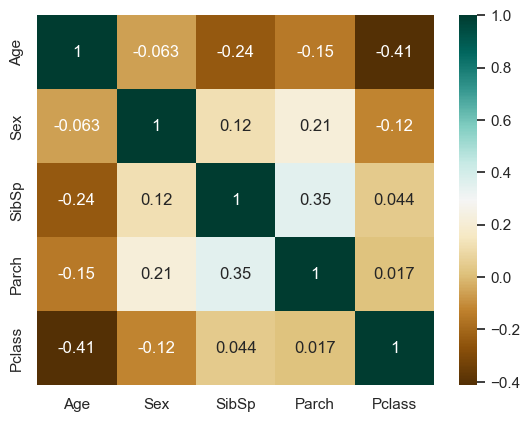

In [33]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

상관관계 map이 Parch를 제외하고 catplot을 확인해준다.

Age와 Sex의 상관도는 매우 낮지만 Pclass, Parch, SibSp와는 음의 상관관계를 갖는다.

Parch에서는 나이가 많을 수록 Parch의 수도 높아졌다. 하지만 전체 상관도는 음수이다.

따라서 Pclass, Parch, SibSp를 결측치를 채우는 데에 사용하기로 한다.

결측치를 채우는 전략은, Pclass, Parch, SibSp에서 비슷한 값을 갖는 행들의 중앙값으로 채우는 것이다.

In [34]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med



C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\2569965295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

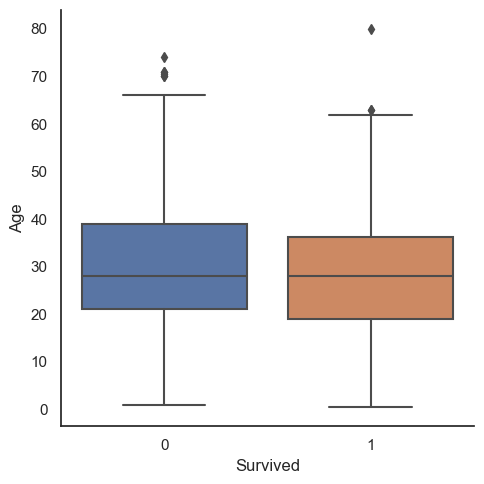

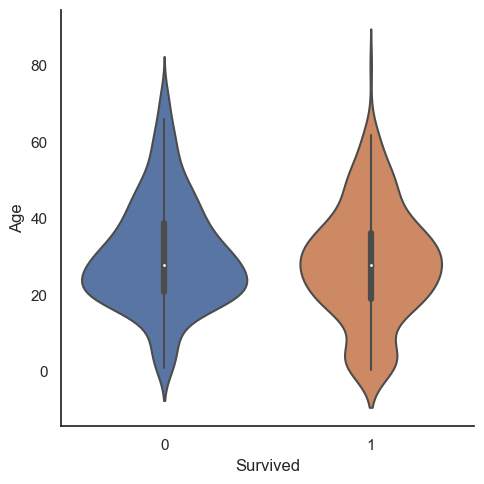

In [35]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

Survived 0과 1에서의 중간값에서 차이가 없다는 것을 확인할 수 있다. 하지만 violin plot을 보면 생존한 승객들 중 어린 나이의 승객에서 생존율이 높은 것을 확인할 수 있다.

## 5. Feature engineering
### 5.1 Name/Title

In [36]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름에 승객의 title이 포함되어 있는데, (Mr, Mrs, Ms 등) 이 title에 따라 구조에 있어 차별화되었을 수 있으니 이것을 모델에 포함하는 것도 흥미로워 보인다.

In [37]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

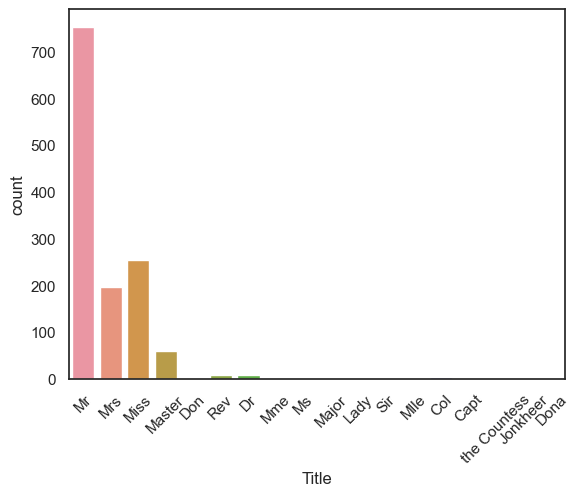

In [38]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

총 17개의 title이 있지만, 상위 4개의 카테고리를 제외하고는 값이 많지 않으므로, 'Rare'로 대체하거나 상위 4개로 편입시키는 것으로 결정한다

In [39]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

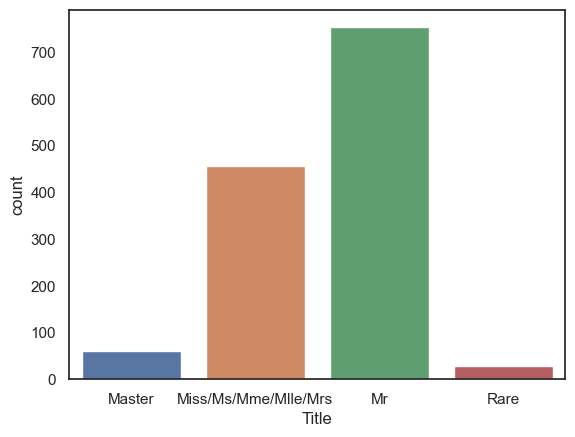

In [40]:
g = sns.countplot(data=dataset, x="Title")
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
plt.show()

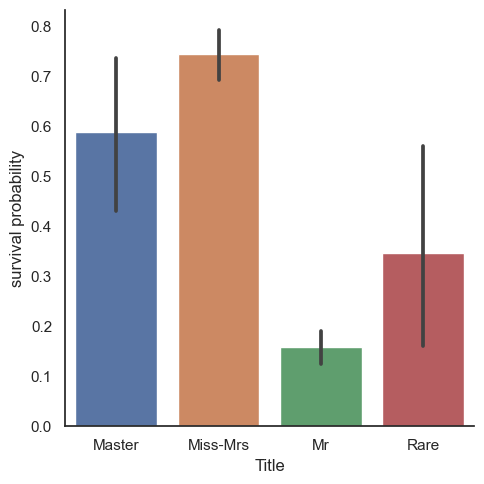

In [41]:
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Women and children first"를 다시 확인할 수 있다. 또한 Rare title을 가진 사람들의 생존율이 더 높은 것도 흥미롭다.

In [42]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size

대체로 가족 구성원 수가 많을 수록 구조가 어려울 것이라 생각할 수 있다. 따라서 SibSp와 Parch를 합친 값에 1을 더해 Fsize 변수를 새로 만들었다.

In [43]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

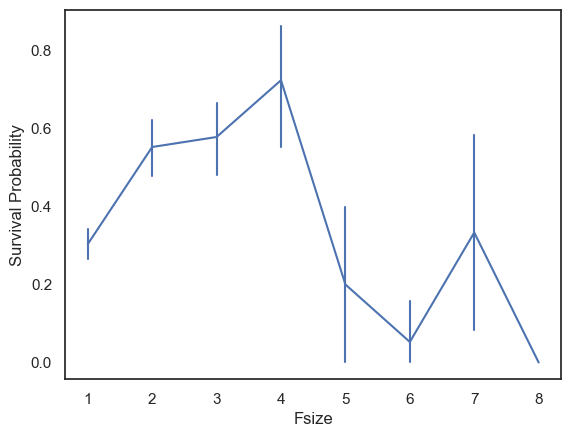

In [44]:
g = sns.lineplot(x="Fsize",y="Survived",data = dataset, err_style='bars')
g = g.set_ylabel("Survival Probability")

Family size가 생존율에 큰 영향을 미치는 것을 확인할 수 있다.

Fsize를 다시 4 카테고리로 나누어 새로운 변수를 만든다.

In [45]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

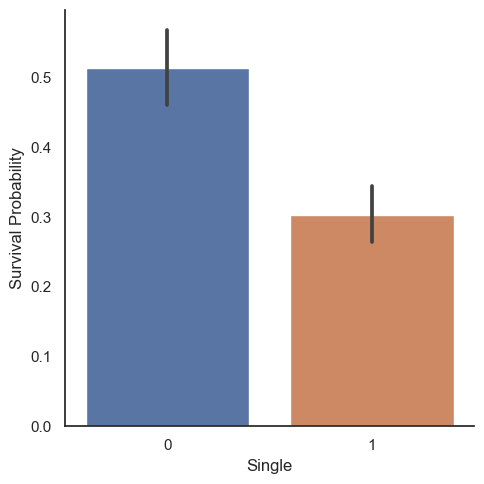

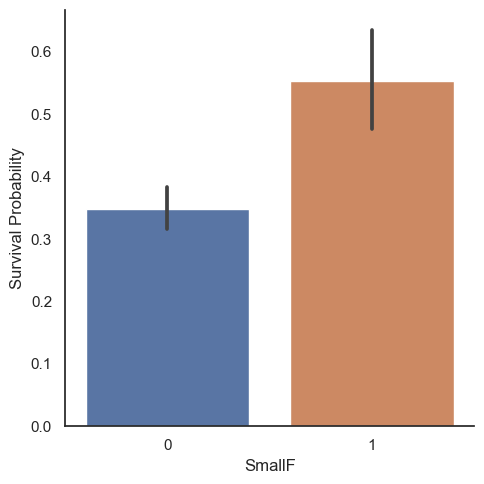

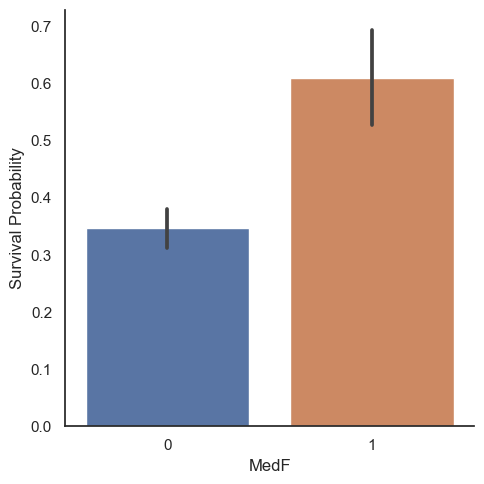

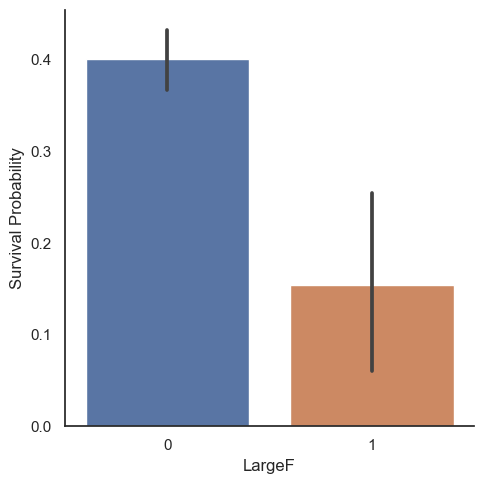

In [46]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Small과 Medium size의 family일수록 생존율이 더 높은 것을 확인할 수 있다.

In [47]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [48]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


현재까지 22개의 변수가 존재한다.

### 5.3 Cabin

In [49]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset["Cabin"].isnull().sum()

1007

Cabin 변수에는 292개의 종류와 1007개의 결측치가 있다.
객실이 없는 승객의 경우 결측치로 채워진 것으로 생각할 수 있다.

In [52]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

Cabin의 첫 글자는 Desk를 의미하고, 이것은 타이타닉호 내부에서 승객의 위치를 암시할 수 있으므로, 이 정보만을 저장하기로 한다. 결측치는 X로 채운다.

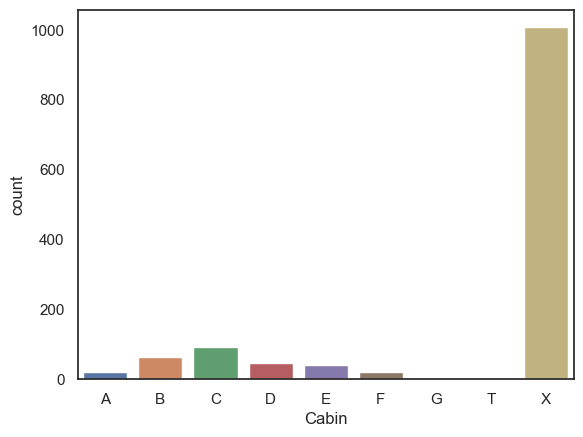

In [54]:
g = sns.countplot(data=dataset, x="Cabin",order=['A','B','C','D','E','F','G','T','X'])

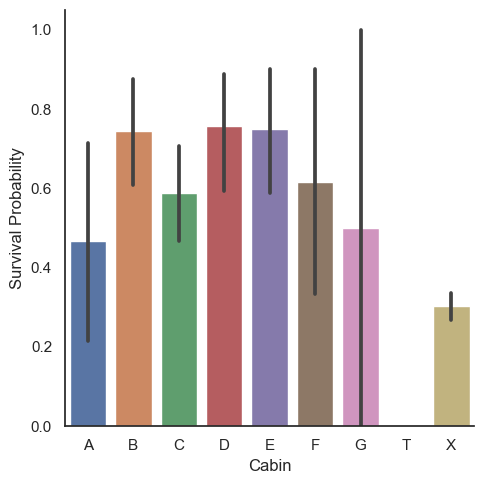

In [55]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

객실이 있는 승객의 수는 적으므로, 생존율 표준 편차는 중요하며, 각 Desk별 승객의 생존율을 구분할 수 없다. 하지만 객실이 있는 승객이 객실이 없는 승객보다 생존율이 높은 것을 확인할 수 있다.
특히 B, C, D, E and F 에서 확인가능하다.

In [56]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [57]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

이는 같은 접두사를 공유하는 ticket이 객실 또한 비슷하다는 것을 의미할 수 있다. 따라서 이는 실제 선박 내에서 실질적인 위치를 의미할 수 있다.

또한 접두어가 같은 ticket은 Class와 생존율이 비슷할 것이라 생각할 수 있다.

따라서 Ticket의 feature column을 ticket 접두사로 대체한다.

In [58]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [60]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [61]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [62]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. MODELING

In [63]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\1673638405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [64]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22476\3125760867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


### 6.1 Simple modeling
#### 6.1.1 Cross validate models

모델링으로 아래의 10가지 분류기를 사용하고, stratified kfold cross validation으로 이들의 정확도를 비교해볼 것이다. 


* SVC
* Decision Tree
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [65]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

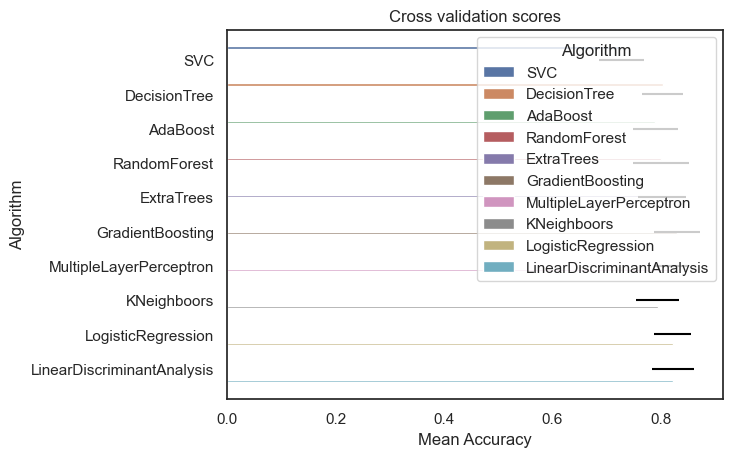

In [67]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, hue="Algorithm", orient="h")
g.errorbar(x=cv_res['CrossValMeans'], y=cv_res['Algorithm'], xerr=cv_std, fmt='none', c='black')
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 앙상블에 사용하기로 결정하였다.

#### 6.1.2 Hyperparameter tunning for best models

AdaBoost, ExtraTrees, RandomForest, GradientBoosting SVC classifiers에 대해 grid search optimization을 실시해보기로 한다.

"n_jobs"를 4로 설정하여 cpu를 4개 사용하기로 한다. 그러면 시간이 단축되는 것을 확인할 수 있다.
시간이 오래 걸린다. 본인의 경우 4 cpu 사용에 15분이 걸렸다.

In [ ]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 608 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    7.3s finished


In [ ]:
gsadaDTC.best_score_

0.82406356413166859

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.8min finished


0.82973893303064694

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.83427922814982969

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   56.6s finished


0.83087400681044266

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   38.6s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.0min finished


0.83314415437003408

#### 6.1.3 Plot learning curves

학습률 곡선을 그려서 모델이 training set에 과적합되고 있지는 않은지, 그리고 training set의 사이즈가 적당한지 알아보자.

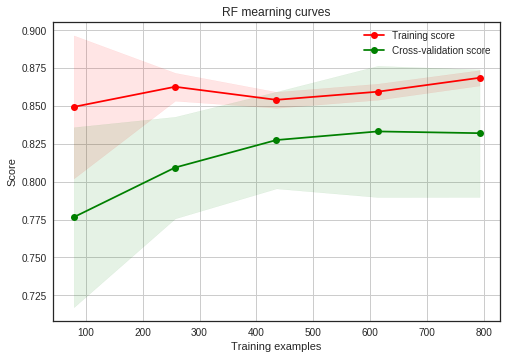

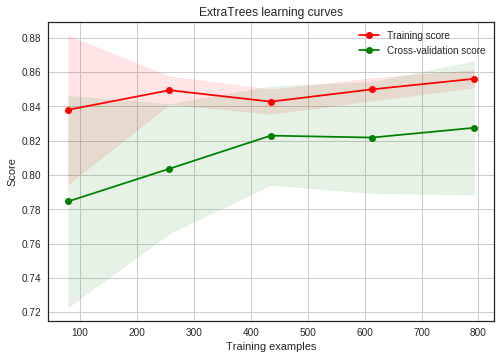

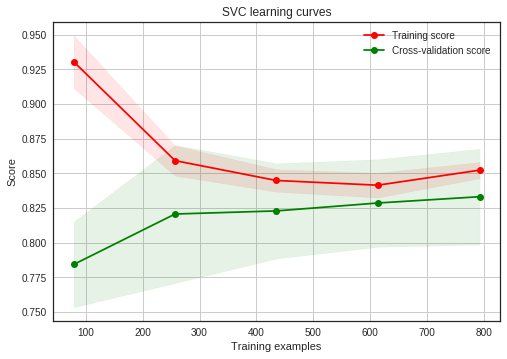

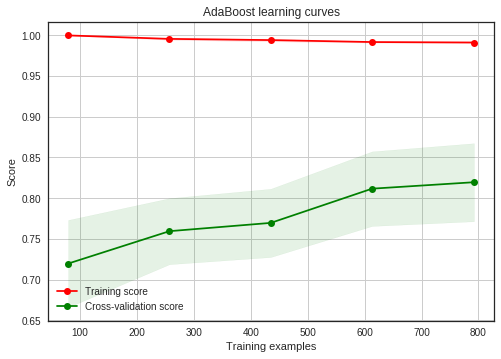

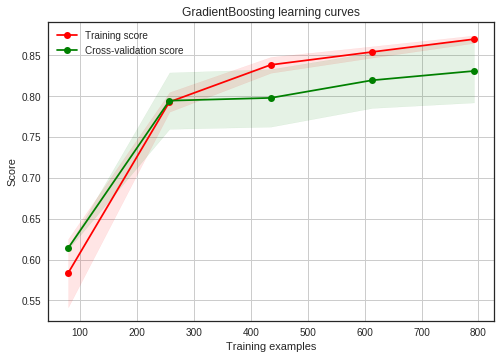

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)



GradientBoosting과 Adaboost classifiers 는 training set에 과적합되는 경향이 있다. 
교차검증이 반복됨에 따라 GradientBoosting와 Adaboost의 cross-validation curve가 높아지는 것을 확인할 수 있다.


SVC 와 ExtraTrees classifiers는 training curve와 cross-validation curve가 인접한 것으로 보아 예측을 더 잘 일반화한다고 생각할 수 있다.

#### 6.1.4 Feature importance of tree based classifiers

생존율 예측에 가장 중요한 피처를 확인하기 위해 4 tree based classifiers에 대해 피처 중요도를 그려보았다.

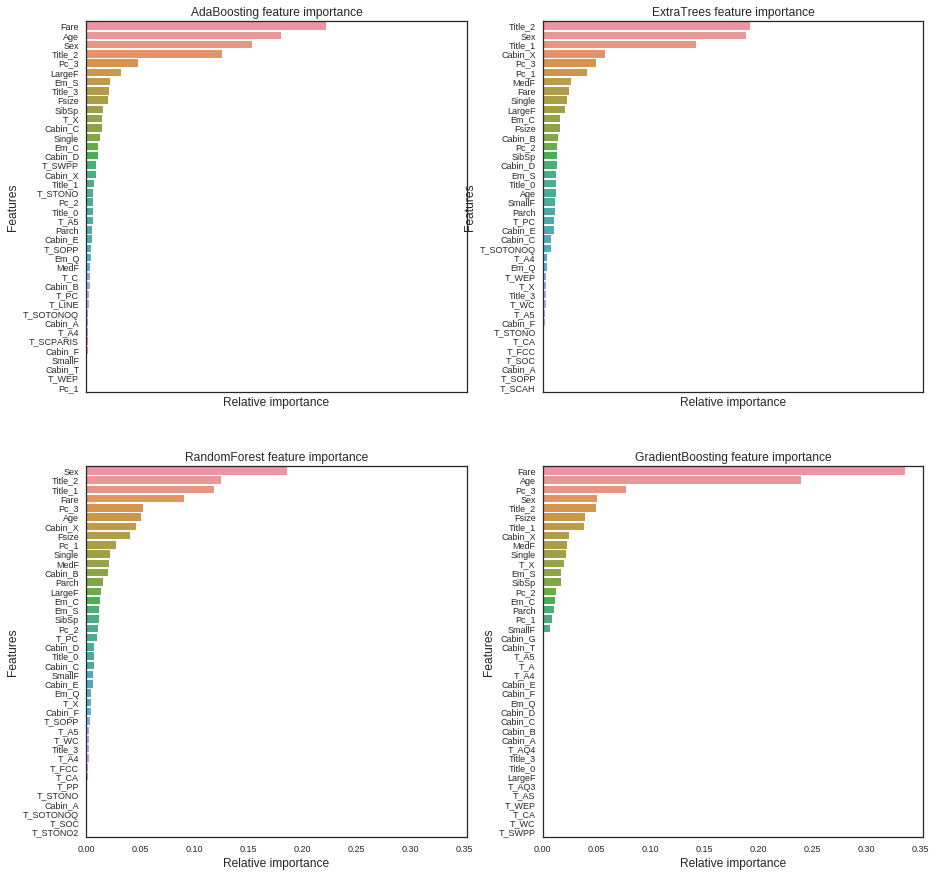

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Adaboost, ExtraTrees, RandomForest and GradientBoosting에 대한 피처 중요도를 그려보았다. 여기서 각 분류기별 가장 중요한 피처가 다른 것을 알 수 있다. 이것은 이 분류기들이 같은 피처를 기반으로 예측하는 것이 아님을 의미한다. 그럼에도, 'Fare', 'Title_2', 'Age' and 'Sex'에 대해서는 비슷한 피처 중요도를 가짐을 알 수 있다. 또한 Title_2, 즉 Mrs/Mlle/Mme/Miss/Ms는 성별과 상관도가 매우 높다.

따라서 이와 같이 말할 수 잇다.

We can say that: 

- Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

- Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

- Age and Title_1 (Master) refer to the age of passengers.

- Fsize, LargeF, MedF, Single refer to the size of the passenger family.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.**

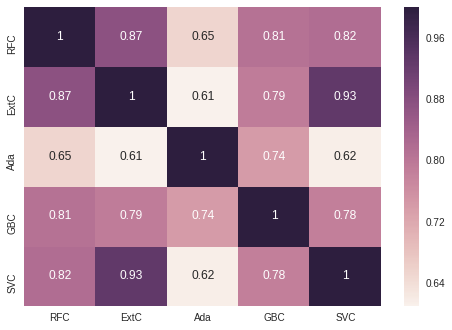

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

Adaboost를 제외하고는 각 분류기별 예측값이 비슷하다. 그러나 차이가 분명히 존재하기 때문에, 앙상블 voting을 진행하기에 좋다.

### 6.2 Ensemble modeling
#### 6.2.1 Combining models

5개 분류기에서의 예측으로 soft voting을 진행한다.


In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)